# Análisis de la IA 14 de Madrid, basandonos en el script de descarga de @alfonsotwr

este es el notebook "funcionando"...

In [2]:
import os.path as pth
import datetime as dt
import time
from glob import glob
import re
import pandas as pd
import numpy as np

import requests
from shutil import copyfile

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.dates import (YEARLY, MONTHLY, DateFormatter, MonthLocator,DayLocator,
                              rrulewrapper, RRuleLocator, drange)
import seaborn as sns
import matplotlib.colors as colors

import numpy as np
from datetime import datetime
import seaborn as sns
%matplotlib inline
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from io import StringIO

In [3]:
expnumber = re.compile(r'^ *(\d+(?: ?\. ?\d+)*)(?:[^\d/]|\s|\(|$|\.[^\d/]|\.\s|\.$)', re.M)

expfecha = re.compile(r'(\d\d)/(\d\d)/(\d\d\d\d)')
expacum = re.compile(r'\n2 \n7 \n11 \n[\d \n]+')
expnumber2 = re.compile(r'\d\d\d\d\d+')


In [4]:
URL_TPL = 'https://www.comunidad.madrid/sites/default/files/doc/sanidad/{:02d}{:02d}{:02d}_cam_covid19.pdf'
FN_TPL = '{:02d}{:02d}{:02d}_cam_covid19.pdf'
FN_TPL_txt = '{:02d}{:02d}{:02d}_cam_covid19.txt'

In [5]:
ALWAYS_UPDATE = True

In [8]:
def descarga(url, fn, isbinary=False, isascii=False, isbackup=False,
             prevpage=None):
    today = dt.date.today()

    ret = True

    if pth.isfile(fn):
        modifiedTime = pth.getmtime(fn)
        changed = dt.datetime.fromtimestamp(modifiedTime).date()

        if isbackup:
            basename = pth.basename(fn)
            rootfn, ext = pth.splitext(basename)
            dirname = pth.dirname(fn)
            changedstr = str(changed)

            backupfn = pth.join(dirname, 'backup',
                                rootfn + '-' + changedstr + ext)
            print('Backup: {} -> {}'.format(fn, backupfn))
            copyfile(fn, backupfn)


    if not pth.isfile(fn) or changed != today or ALWAYS_UPDATE:
        print('Descargando:', url)
        headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
        with requests.Session() as s:
            if prevpage:
                s.get(prevpage, headers=headers)
            r = s.get(url, headers=headers)
        if r.status_code == requests.codes.ok:
            if isbinary:
                with open(fn, 'wb') as fp:
                    fp.write(r.content)
            elif isascii:
                content = r.content
                text = r.content.decode('ascii', 'ignore')
                with open(fn, 'w', encoding='utf-8') as fp:
                    fp.write(text)
            else:
                with open(fn, 'w', encoding='utf-8') as fp:
                    fp.write(r.text)
        else:
            print('ERROR', r.status_code, 'descargando:', fn)
            ret = False

    return ret

In [16]:
def descargacam():
    today = dt.date.today()

    current = dt.date(2020, 8, 15)

    pdfdir = 'data/'
    if pth.isdir(pdfdir):
        datadir = 'data/'
    else:
        pdfdir = ''
        datadir = ''

    while current <= today:
        if current > dt.date(2020, 7, 1) and current.weekday() in [5, 6]:
            current += dt.timedelta(1)
            continue
        fn = pdfdir + FN_TPL.format(current.year % 100, current.month, current.day)
        url = URL_TPL.format(current.year % 100, current.month, current.day)

        if not pth.exists(fn):
            ret = descarga(url, fn, isbinary=True)
            time.sleep(1)
            if not ret:
                changed = False
                if current == dt.date(2020, 8, 3):  # special cases
                    url = url.replace('03_', '03')
                    changed = True
                elif current == dt.date(2020, 8, 14):  # special cases
                    url = url.replace('/20', '/2020')
                    changed = True
                elif current == dt.date(2020, 9, 2):  # special cases
                    url = url.replace('/doc/sanidad', '')
                    changed = True
                if changed:
                    descarga(url, fn, isbinary=True)
                    time.sleep(1)

        current += dt.timedelta(1)

    csvfn = datadir + 'madrid-series.csv'
    df = pd.DataFrame()

    for fn in sorted(glob(pdfdir + '20*_cam_covid19.pdf')):
        fn1 = fn.replace('.pdf', '_1.txt')
        fn2 = fn.replace('.pdf', '_2.txt')
        fn3 = fn.replace('.pdf', '_3.txt')
        if not pth.isfile(fn1):
            print('Creating:', fn1)
            page1 = pdf_to_text(fn, pagenum=0)
            with open(fn1, 'w', encoding='utf-8') as fp:
                fp.write(page1)
        if not pth.isfile(fn2):
            print('Creating:', fn2)
            page2 = pdf_to_text(fn, pagenum=1)
            with open(fn2, 'w', encoding='utf-8') as fp:
                fp.write(page2)
        if not pth.isfile(fn3):
            print('Creating:', fn3)
            page3 = pdf_to_text(fn, pagenum=2)
            with open(fn3, 'w', encoding='utf-8') as fp:
                fp.write(page3)

    for fn in sorted(glob(pdfdir + '20*_cam_covid19_1.txt')):
        print(fn)
        base = pth.basename(fn)
        year = 2000 + int(base[:2])
        month = int(base[2:4])
        day = int(base[4:6])

        date = dt.datetime(year, month, day)

        # if date > dt.datetime(2020, 7, 13):
        #     break

        with open(fn, encoding='utf-8') as fp:
            text = fp.read()

        # A partir de aquí debe de ser cambiado si cambia el formato de los
        # informes de la Consejería
        numbers = [int(m.group(0).replace('.', '').replace(' ', ''))
                   for m in expnumber.finditer(text)]

        if date < dt.datetime(2020, 5, 13):
            hospitalizados = numbers[11]
            uci = numbers[12]
            fallecidos = numbers[15]
            recuperados = numbers[14]
            domicilio = numbers[13]
            if numbers[3] > 55000:
                hospitalizados_sin_uci_dia = numbers[6]
                uci_dia = numbers[7]
                pcr = numbers[3]
                # casos = numbers[5]
                domicilio_dia = numbers[8]
                altas_dia = numbers[9]
                fallecidos_dia = numbers[10]
            else:
                hospitalizados_sin_uci_dia = numbers[3]
                pcr = numbers[8]
                uci_dia = numbers[4]
                # casos = numbers[10]
                domicilio_dia = numbers[5]
                altas_dia = numbers[6]
                fallecidos_dia = numbers[7]

            muertos_hospitales = numbers[16]
            muertos_domicilios = numbers[17]
            muertos_centros = numbers[18]
            muertos_otros = numbers[19]
            muertos = numbers[20]
        else:
            # print(text)
            # print([(ix, jx) for ix, jx in enumerate(numbers)])

            if date >= dt.datetime(2020, 9, 29):
                fmt = 1
            elif date >= dt.datetime(2020, 7, 13):
                fmt = 2
            elif date >= dt.datetime(2020, 5, 20):
                fmt = 1
            else:
                fmt = 0

            if fmt == 0:
                assert len(numbers) == 20, 'Formato no contemplado'
                pcr = numbers[2]
                hospitalizados_sin_uci_dia = numbers[5]
                hospitalizados = numbers[6]

                uci_dia = numbers[7]
                uci = numbers[8]

                fallecidos_dia = numbers[16]
                fallecidos = numbers[17]

                domicilio_dia = numbers[18]
                domicilio = numbers[19]

                muertos_centros = numbers[9]
                muertos_hospitales = numbers[10]
                muertos_domicilios = numbers[11]
                muertos_otros = numbers[12]
                muertos = numbers[13]

                altas_dia = numbers[14]
                recuperados = numbers[15]
            elif fmt == 1:
                assert len(numbers) == 18, 'Formato no contemplado'
                pcr = numbers[2]
                hospitalizados_sin_uci_dia = numbers[3]
                hospitalizados = numbers[4]
                uci_dia = numbers[5]
                uci = numbers[6]

                fallecidos_dia = numbers[7]
                fallecidos = numbers[8]

                domicilio_dia = numbers[14]
                domicilio = numbers[15]

                muertos_centros = numbers[9]
                muertos_hospitales = numbers[10]
                muertos_domicilios = numbers[11]
                muertos_otros = numbers[12]
                muertos = numbers[13]

                altas_dia = numbers[16]
                recuperados = numbers[17]
            elif fmt == 2:
                assert len(numbers) == 18, 'Formato no contemplado'
                pcr = numbers[2]
                hospitalizados_sin_uci_dia = numbers[3]
                hospitalizados = numbers[4]
                uci_dia = numbers[5]
                uci = numbers[6]

                fallecidos_dia = numbers[14]
                fallecidos = numbers[15]

                domicilio_dia = numbers[16]
                domicilio = numbers[17]

                muertos_centros = numbers[7]
                muertos_hospitales = numbers[8]
                muertos_domicilios = numbers[9]
                muertos_otros = numbers[10]
                muertos = numbers[11]

                altas_dia = numbers[12]
                recuperados = numbers[13]
            else:
                assert False, 'fmt incorrecto'

        hospitalizados_dia = hospitalizados_sin_uci_dia + uci_dia

        df.loc[date, 'CASOS_PCR'] = pcr
        df.loc[date, 'Hospitalizados'] = hospitalizados
        df.loc[date, 'UCI'] = uci
        df.loc[date, 'Fallecidos'] = fallecidos
        df.loc[date, 'Recuperados'] = recuperados
        df.loc[date, 'domicilio'] = domicilio
        df.loc[date, 'uci_dia'] = uci_dia
        df.loc[date, 'hospitalizados_dia'] = hospitalizados_dia
        df.loc[date, 'domicilio_dia'] = domicilio_dia
        df.loc[date, 'altas_dia'] = altas_dia
        df.loc[date, 'fallecidos_dia'] = fallecidos_dia
        df.loc[date, 'muertos_hospitales'] = muertos_hospitales
        df.loc[date, 'muertos_domicilios'] = muertos_domicilios
        df.loc[date, 'muertos_centros'] = muertos_centros
        df.loc[date, 'muertos_otros'] = muertos_otros
        df.loc[date, 'muertos'] = muertos

    df = df.astype(int)
    df.index.name = 'Fecha'
    print('Escribiendo', csvfn)
    df.to_csv(csvfn, line_terminator='\r\n')

    # return  # Para no crear serie PCR

    fn2 = sorted(glob(pdfdir + '20*_cam_covid19_2.txt'))[-1]
    fn3 = fn2.replace('_2.txt', '_3.txt')
    print(fn2)
    with open(fn2, encoding='utf-8') as fp:
        text = fp.read()

    m = expacum.search(text)

    assert m, 'Debe ajustarse expacum con los primeros valores'

    accum = [int(x) for x in m.group().split()]

    dates = []
    for m in expfecha.finditer(text):
        dates.append(dt.datetime(int(m.group(3)), int(m.group(2)),
                                 int(m.group(1))))

    accum2 = [int(x.group()) for x in expnumber2.finditer(text)
              if int(x.group()) > accum[-1]]
    accum += accum2

    assert len(accum) == len(dates), 'La serie acumulada no concuerda para _2'

    print(fn3)
    with open(fn3, encoding='utf-8') as fp:
        text = fp.read()

    dates2 = []
    for m in expfecha.finditer(text):
        dates2.append(dt.datetime(int(m.group(3)), int(m.group(2)),
                                  int(m.group(1))))
    dates += sorted(dates2)

    accum2 = [int(x.group()) for x in expnumber2.finditer(text)]
    accum += sorted(accum2)

    assert len(accum) == len(dates), 'La serie acumulada no concuerda para _3'

    sr = pd.Series(accum, index=dates).sort_index()
    sr.name = 'PCR+'
    sr.index.name = 'Fecha'
    df2 = sr.to_frame()

    if df.index[-1] != df2.index[-1] + dt.timedelta(1):
        raise RuntimeError('Última fecha de las tablas no coincide')

    # pd.set_option('display.max_rows', None)
    # print(sr)
    # print(sr.diff())
    assert all(sr.diff().dropna() >= 0), 'La serie acumulada no es creciente'
    assert all((sr.index[1:] - sr.index[:-1]).days > 0), 'Fechas no suben'

    csvfn = datadir + 'madrid-pcr.csv'
    print('Escribiendo', csvfn)
    df2.to_csv(csvfn, line_terminator='\r\n')

    print('ESTÁ ACTUALIZADO' if today == df.index[-1].date() else
          '******************* NO ESTÁ ACTUALIZADO')


In [39]:
# descarga

today = dt.date.today()
today = dt.date(2020,10,2)
current = dt.date(2020, 10, 2)

pdfdir = 'data/'
if pth.isdir(pdfdir):
    datadir = 'data/'
else:
    pdfdir = ''
    datadir = ''

while current <= today:
    if current > dt.date(2020, 7, 1) and current.weekday() in [5, 6]:
        current += dt.timedelta(1)
        continue
    fn = pdfdir + FN_TPL.format(current.year % 100, current.month, current.day)
    url = URL_TPL.format(current.year % 100, current.month, current.day)

    if not pth.exists(fn):
        ret = descarga(url, fn, isbinary=True)
        time.sleep(1)
        if not ret:
            changed = False
            if current == dt.date(2020, 8, 3):  # special cases
                url = url.replace('03_', '03')
                changed = True
            elif current == dt.date(2020, 8, 14):  # special cases
                url = url.replace('/20', '/2020')
                changed = True
            elif current == dt.date(2020, 9, 2):  # special cases
                url = url.replace('/doc/sanidad', '')
                changed = True
            if changed:
                descarga(url, fn, isbinary=True)
                time.sleep(1)

    current += dt.timedelta(1)

Descargando: https://www.comunidad.madrid/sites/default/files/doc/sanidad/201002_cam_covid19.pdf


In [135]:
#Creating

csvfn = datadir + 'madrid-series.csv'
df = pd.DataFrame()

for fn in sorted(glob(pdfdir + '20*_cam_covid19.pdf')):
    fn1 = fn.replace('.pdf', '_1.txt')
    fn2 = fn.replace('.pdf', '_2.txt')
    fn3 = fn.replace('.pdf', '_3.txt')
    if not pth.isfile(fn1):
        print('Creating:', fn1)
        page1 = pdf_to_text(fn, pagenum=0)
        with open(fn1, 'w', encoding='utf-8') as fp:
            fp.write(page1)
    if not pth.isfile(fn2):
        print('Creating:', fn2)
        page2 = pdf_to_text(fn, pagenum=1)
        #with open(fn2, 'w', encoding='utf-8') as fp:
        with open(fn2, 'w') as fp:   
            fp.write(page2)
    if not pth.isfile(fn3):
        print('Creating:', fn3)
        page3 = pdf_to_text(fn, pagenum=2)
        with open(fn3, 'w', encoding='utf-8') as fp:
            fp.write(page3)

In [41]:
for fn in sorted(glob(pdfdir + '20*_cam_covid19_1.txt')):
    print(fn)
    base = pth.basename(fn)
    year = 2000 + int(base[:2])
    month = int(base[2:4])
    day = int(base[4:6])

    date = dt.datetime(year, month, day)

    # if date > dt.datetime(2020, 7, 13):
    #     break

    with open(fn, encoding='utf-8') as fp:
        text = fp.read()

    # A partir de aquí debe de ser cambiado si cambia el formato de los
    # informes de la Consejería
    numbers = [int(m.group(0).replace('.', '').replace(' ', ''))
                for m in expnumber.finditer(text)]

    if date < dt.datetime(2020, 5, 13):
        hospitalizados = numbers[11]
        uci = numbers[12]
        fallecidos = numbers[15]
        recuperados = numbers[14]
        domicilio = numbers[13]
        if numbers[3] > 55000:
            hospitalizados_sin_uci_dia = numbers[6]
            uci_dia = numbers[7]
            pcr = numbers[3]
            # casos = numbers[5]
            domicilio_dia = numbers[8]
            altas_dia = numbers[9]
            fallecidos_dia = numbers[10]
        else:
            hospitalizados_sin_uci_dia = numbers[3]
            pcr = numbers[8]
            uci_dia = numbers[4]
            # casos = numbers[10]
            domicilio_dia = numbers[5]
            altas_dia = numbers[6]
            fallecidos_dia = numbers[7]

        muertos_hospitales = numbers[16]
        muertos_domicilios = numbers[17]
        muertos_centros = numbers[18]
        muertos_otros = numbers[19]
        muertos = numbers[20]
    else:
        #print(text)
        # print([(ix, jx) for ix, jx in enumerate(numbers)])

        if date >= dt.datetime(2020, 9, 29):
            fmt = 1
        elif date >= dt.datetime(2020, 7, 13):
            fmt = 2
        elif date >= dt.datetime(2020, 5, 20):
            fmt = 1
        else:
            fmt = 0

        if fmt == 0:
            assert len(numbers) == 20, 'Formato no contemplado'
            pcr = numbers[2]
            hospitalizados_sin_uci_dia = numbers[5]
            hospitalizados = numbers[6]

            uci_dia = numbers[7]
            uci = numbers[8]

            fallecidos_dia = numbers[16]
            fallecidos = numbers[17]

            domicilio_dia = numbers[18]
            domicilio = numbers[19]

            muertos_centros = numbers[9]
            muertos_hospitales = numbers[10]
            muertos_domicilios = numbers[11]
            muertos_otros = numbers[12]
            muertos = numbers[13]

            altas_dia = numbers[14]
            recuperados = numbers[15]
        elif fmt == 1:
            assert len(numbers) == 18, 'Formato no contemplado'
            pcr = numbers[2]
            hospitalizados_sin_uci_dia = numbers[3]
            hospitalizados = numbers[4]
            uci_dia = numbers[5]
            uci = numbers[6]

            fallecidos_dia = numbers[7]
            fallecidos = numbers[8]

            domicilio_dia = numbers[14]
            domicilio = numbers[15]

            muertos_centros = numbers[9]
            muertos_hospitales = numbers[10]
            muertos_domicilios = numbers[11]
            muertos_otros = numbers[12]
            muertos = numbers[13]

            altas_dia = numbers[16]
            recuperados = numbers[17]
        elif fmt == 2:
            assert len(numbers) == 18, 'Formato no contemplado'
            pcr = numbers[2]
            hospitalizados_sin_uci_dia = numbers[3]
            hospitalizados = numbers[4]
            uci_dia = numbers[5]
            uci = numbers[6]

            fallecidos_dia = numbers[14]
            fallecidos = numbers[15]

            domicilio_dia = numbers[16]
            domicilio = numbers[17]

            muertos_centros = numbers[7]
            muertos_hospitales = numbers[8]
            muertos_domicilios = numbers[9]
            muertos_otros = numbers[10]
            muertos = numbers[11]

            altas_dia = numbers[12]
            recuperados = numbers[13]
        else:
            assert False, 'fmt incorrecto'
         
    hospitalizados_dia = hospitalizados_sin_uci_dia + uci_dia

    df.loc[date, 'CASOS_PCR'] = pcr
    df.loc[date, 'Hospitalizados'] = hospitalizados
    df.loc[date, 'UCI'] = uci
    df.loc[date, 'Fallecidos'] = fallecidos
    df.loc[date, 'Recuperados'] = recuperados
    df.loc[date, 'domicilio'] = domicilio
    df.loc[date, 'uci_dia'] = uci_dia
    df.loc[date, 'hospitalizados_dia'] = hospitalizados_dia
    df.loc[date, 'domicilio_dia'] = domicilio_dia
    df.loc[date, 'altas_dia'] = altas_dia
    df.loc[date, 'fallecidos_dia'] = fallecidos_dia
    df.loc[date, 'muertos_hospitales'] = muertos_hospitales
    df.loc[date, 'muertos_domicilios'] = muertos_domicilios
    df.loc[date, 'muertos_centros'] = muertos_centros
    df.loc[date, 'muertos_otros'] = muertos_otros
    df.loc[date, 'muertos'] = muertos   
    df = df.astype(int)
df.index.name = 'Fecha'
print('Escribiendo', csvfn)
df.to_csv(csvfn, line_terminator='\r\n')

data/201002_cam_covid19_1.txt
Escribiendo data/madrid-series.csv


In [42]:
df.head()

,CASOS_PCR,Hospitalizados,UCI,Fallecidos,Recuperados,domicilio,uci_dia,hospitalizados_dia,domicilio_dia,altas_dia,fallecidos_dia,muertos_hospitales,muertos_domicilios,muertos_centros,muertos_otros,muertos
Fecha,,,,,,,,,,,,,,,,
2020-10-02,249483,58927,5153,10504,53890,439679,505,3489,8186,339,37,10762,1032,4874,30,16698


In [43]:


# return  # Para no crear serie PCR

fn2 = sorted(glob(pdfdir + '20*_cam_covid19_2.txt'))[-1]
fn3 = fn2.replace('_2.txt', '_3.txt')
print(fn2)
with open(fn2, encoding='utf-8') as fp:
    text = fp.read()

m = expacum.search(text)

assert m, 'Debe ajustarse expacum con los primeros valores'

accum = [int(x) for x in m.group().split()]

dates = []
for m in expfecha.finditer(text):
    dates.append(dt.datetime(int(m.group(3)), int(m.group(2)),
                                int(m.group(1))))

accum2 = [int(x.group()) for x in expnumber2.finditer(text)
            if int(x.group()) > accum[-1]]
accum += accum2

assert len(accum) == len(dates), 'La serie acumulada no concuerda para _2'

print(fn3)
with open(fn3, encoding='utf-8') as fp:
    text = fp.read()

dates2 = []
for m in expfecha.finditer(text):
    dates2.append(dt.datetime(int(m.group(3)), int(m.group(2)),
                                  int(m.group(1))))
dates += sorted(dates2)

accum2 = [int(x.group()) for x in expnumber2.finditer(text)]
accum += sorted(accum2)

assert len(accum) == len(dates), 'La serie acumulada no concuerda para _3'

sr = pd.Series(accum, index=dates).sort_index()
sr.name = 'PCR+'
sr.index.name = 'Fecha'
df2 = sr.to_frame()

if df.index[-1] != df2.index[-1] + dt.timedelta(1):
    raise RuntimeError('Última fecha de las tablas no coincide')

# pd.set_option('display.max_rows', None)
# print(sr)
# print(sr.diff())
assert all(sr.diff().dropna() >= 0), 'La serie acumulada no es creciente'
assert all((sr.index[1:] - sr.index[:-1]).days > 0), 'Fechas no suben'

csvfn = datadir + 'madrid-pcr.csv'
print('Escribiendo', csvfn)
df2.to_csv(csvfn, line_terminator='\r\n')

print('ESTÁ ACTUALIZADO' if today == df.index[-1].date() else
        '******************* NO ESTÁ ACTUALIZADO')


data/201002_cam_covid19_2.txt
data/201002_cam_covid19_3.txt
Escribiendo data/madrid-pcr.csv
ESTÁ ACTUALIZADO


In [6]:
# Extract PDF text using PDFMiner. Adapted from
# http://stackoverflow.com/questions/5725278/python-help-using-pdfminer-as-a-library

def pdf_to_text(pdfname, pagenum=None):

    # PDFMiner boilerplate
    rsrcmgr = PDFResourceManager()
    sio = StringIO()
    laparams = LAParams()
    device = None
    try:
        device = TextConverter(rsrcmgr, sio, laparams=laparams)
        interpreter = PDFPageInterpreter(rsrcmgr, device)

        # Extract text
        with open(pdfname, 'rb') as fp:
            for i, page in enumerate(PDFPage.get_pages(fp)):
                if pagenum is None or pagenum == i:
                    interpreter.process_page(page)

        # Get text from StringIO
        text = sio.getvalue()
    finally:
        # Cleanup
        sio.close()
        if device is not None:
            device.close()

    return text

In [38]:
df2.tail(20)

,PCR+
Fecha,
2020-09-12,192338
2020-09-13,193663
2020-09-14,195811
2020-09-15,201373
2020-09-16,206474
2020-09-17,211419
2020-09-18,218077
2020-09-19,219692
2020-09-20,220703


In [18]:
descargacam()

Descargando: https://www.comunidad.madrid/sites/default/files/doc/sanidad/200817_cam_covid19.pdf
Descargando: https://www.comunidad.madrid/sites/default/files/doc/sanidad/200818_cam_covid19.pdf
Descargando: https://www.comunidad.madrid/sites/default/files/doc/sanidad/200819_cam_covid19.pdf
Descargando: https://www.comunidad.madrid/sites/default/files/doc/sanidad/200820_cam_covid19.pdf
Descargando: https://www.comunidad.madrid/sites/default/files/doc/sanidad/200821_cam_covid19.pdf
Descargando: https://www.comunidad.madrid/sites/default/files/doc/sanidad/200824_cam_covid19.pdf
Descargando: https://www.comunidad.madrid/sites/default/files/doc/sanidad/200825_cam_covid19.pdf
Descargando: https://www.comunidad.madrid/sites/default/files/doc/sanidad/200826_cam_covid19.pdf
Descargando: https://www.comunidad.madrid/sites/default/files/doc/sanidad/200827_cam_covid19.pdf
Descargando: https://www.comunidad.madrid/sites/default/files/doc/sanidad/200828_cam_covid19.pdf
Descargando: https://www.comun

In [10]:
#descargamos los ficheros pdf
today = dt.date.today()
desde = dt.date(2020,9,1)
dia = dt.date(2020,9,2)
date_array = date_array = np.arange(desde, today,
                                    np.timedelta64(1,'D'), dtype='datetime64')
for dia in date_array:
    pdfdir = 'data/'
    dia_dt = dia.item()
    if dia_dt.weekday() in [5,6]:
        continue
    fn = pdfdir + FN_TPL.format(dia_dt.year % 100, dia_dt.month, dia_dt.day)
    url = URL_TPL.format(dia_dt.year % 100, dia_dt.month, dia_dt.day)
    ret = descarga(url, fn, isbinary=True)
    time.sleep(1)
    if not ret:
        changed = False
        if dia_dt == dt.date(2020, 9, 2):  # special cases
                url = url.replace('/doc/sanidad', '')
                changed = True
        if changed:
            descarga(url, fn, isbinary=True)
            time.sleep(1)

Descargando: https://www.comunidad.madrid/sites/default/files/doc/sanidad/200901_cam_covid19.pdf
Descargando: https://www.comunidad.madrid/sites/default/files/doc/sanidad/200902_cam_covid19.pdf
ERROR 404 descargando: data/200902_cam_covid19.pdf
Descargando: https://www.comunidad.madrid/sites/default/files/200902_cam_covid19.pdf
Descargando: https://www.comunidad.madrid/sites/default/files/doc/sanidad/200903_cam_covid19.pdf
Descargando: https://www.comunidad.madrid/sites/default/files/doc/sanidad/200904_cam_covid19.pdf
Descargando: https://www.comunidad.madrid/sites/default/files/doc/sanidad/200907_cam_covid19.pdf
Descargando: https://www.comunidad.madrid/sites/default/files/doc/sanidad/200908_cam_covid19.pdf
Descargando: https://www.comunidad.madrid/sites/default/files/doc/sanidad/200909_cam_covid19.pdf
Descargando: https://www.comunidad.madrid/sites/default/files/doc/sanidad/200910_cam_covid19.pdf
Descargando: https://www.comunidad.madrid/sites/default/files/doc/sanidad/200911_cam_cov

In [11]:
#Creamos los txt con los datos

for fn in sorted(glob(pdfdir + '20*_cam_covid19.pdf')):
    fn1 = fn.replace('.pdf', '_1.txt')
    fn2 = fn.replace('.pdf', '_2.txt')
    fn3 = fn.replace('.pdf', '_3.txt')
    if not pth.isfile(fn1):
        print('Creating:', fn1)
        page1 = pdf_to_text(fn, pagenum=0)
        with open(fn1, 'w', encoding='utf-8') as fp:
            fp.write(page1)
    if not pth.isfile(fn2):
        print('Creating:', fn2)
        page2 = pdf_to_text(fn, pagenum=1)
        #with open(fn2, 'w', encoding='utf-8') as fp:
        with open(fn2, 'w') as fp:    
            fp.write(page2)
    if not pth.isfile(fn3):
        print('Creating:', fn3)
        page3 = pdf_to_text(fn, pagenum=2)
        with open(fn3, 'w', encoding='utf-8') as fp:
            fp.write(page3)

Creating: data/200901_cam_covid19_1.txt
Creating: data/200901_cam_covid19_2.txt
Creating: data/200901_cam_covid19_3.txt
Creating: data/200902_cam_covid19_1.txt
Creating: data/200902_cam_covid19_2.txt
Creating: data/200902_cam_covid19_3.txt
Creating: data/200903_cam_covid19_1.txt
Creating: data/200903_cam_covid19_2.txt
Creating: data/200903_cam_covid19_3.txt
Creating: data/200904_cam_covid19_1.txt
Creating: data/200904_cam_covid19_2.txt
Creating: data/200904_cam_covid19_3.txt
Creating: data/200907_cam_covid19_1.txt
Creating: data/200907_cam_covid19_2.txt
Creating: data/200907_cam_covid19_3.txt
Creating: data/200908_cam_covid19_1.txt
Creating: data/200908_cam_covid19_2.txt
Creating: data/200908_cam_covid19_3.txt
Creating: data/200909_cam_covid19_1.txt
Creating: data/200909_cam_covid19_2.txt
Creating: data/200909_cam_covid19_3.txt
Creating: data/200910_cam_covid19_1.txt
Creating: data/200910_cam_covid19_2.txt
Creating: data/200910_cam_covid19_3.txt
Creating: data/200911_cam_covid19_1.txt


In [14]:
#Creamos los txt con los datos
desde = dt.date(2020,9,1)
today = dt.date.today()
date_array = date_array = np.arange(desde, today,
                                    np.timedelta64(1,'D'), dtype='datetime64')
for dia in date_array:
    dia_dt = dia.item()
    if dia_dt.weekday() in [5,6]:
        continue
    
    fn = pdfdir + FN_TPL.format(dia_dt.year % 100, dia_dt.month, dia_dt.day)
    #print(fn)
    fn1 = fn.replace('.pdf', '_1.txt')
    fn2 = fn.replace('.pdf', '_2.txt')
    fn3 = fn.replace('.pdf', '_3.txt')
    
    print('Creating:', fn1)
    page1 = pdf_to_text(fn, pagenum=0)
    #with open(fn1, 'w', encoding='utf-8') as fp:
    with open(fn1, 'w') as fp:    
        fp.write(page1)
    
    print('Creating:', fn2)
    page2 = pdf_to_text(fn, pagenum=1)
    #with open(fn2, 'w', encoding='utf-8') as fp:
    with open(fn2, 'w') as fp:     
        fp.write(page2)
    
    print('Creating:', fn3)
    page3 = pdf_to_text(fn, pagenum=2)
    #with open(fn3, 'w', encoding='utf-8') as fp:
    with open(fn3, 'w') as fp:
        fp.write(page3)

Creating: data/200901_cam_covid19_1.txt
Creating: data/200901_cam_covid19_2.txt
Creating: data/200901_cam_covid19_3.txt
Creating: data/200902_cam_covid19_1.txt
Creating: data/200902_cam_covid19_2.txt
Creating: data/200902_cam_covid19_3.txt
Creating: data/200903_cam_covid19_1.txt
Creating: data/200903_cam_covid19_2.txt
Creating: data/200903_cam_covid19_3.txt
Creating: data/200904_cam_covid19_1.txt
Creating: data/200904_cam_covid19_2.txt
Creating: data/200904_cam_covid19_3.txt
Creating: data/200907_cam_covid19_1.txt
Creating: data/200907_cam_covid19_2.txt
Creating: data/200907_cam_covid19_3.txt
Creating: data/200908_cam_covid19_1.txt
Creating: data/200908_cam_covid19_2.txt
Creating: data/200908_cam_covid19_3.txt
Creating: data/200909_cam_covid19_1.txt
Creating: data/200909_cam_covid19_2.txt
Creating: data/200909_cam_covid19_3.txt
Creating: data/200910_cam_covid19_1.txt
Creating: data/200910_cam_covid19_2.txt
Creating: data/200910_cam_covid19_3.txt
Creating: data/200911_cam_covid19_1.txt


In [16]:
datadir = 'data/'
csvfn = datadir + 'madrid-series.csv'
desde = dt.date(2020,9,1)
date_array = date_array = np.arange(desde, today,
                                    np.timedelta64(1,'D'), dtype='datetime64')
for dia in date_array:
    df = pd.DataFrame()
    pdfdir = 'data/'
    dia_dt = dia.item()
    if dia_dt.weekday() in [5,6]:
        continue
    fn = pdfdir + FN_TPL.format(dia_dt.year % 100, dia_dt.month, dia_dt.day)
    #print(fn)
    fn2 = fn.replace('.pdf', '_2.txt')
    fn3 = fn2.replace('_2.txt', '_3.txt')
    print(fn2)
    #with open(fn2, encoding='utf-8') as fp:
    with open(fn2) as fp:
        text = fp.read()

    m = expacum.search(text)

    assert m, 'Debe ajustarse expacum con los primeros valores'

    accum = [int(x) for x in m.group().split()]

    dates = []
    for m in expfecha.finditer(text):
        dates.append(dt.datetime(int(m.group(3)), int(m.group(2)),
                                    int(m.group(1))))

    accum2 = [int(x.group()) for x in expnumber2.finditer(text)
            if int(x.group()) > accum[-1]]
    accum += accum2

    assert len(accum) == len(dates), 'La serie acumulada no concuerda para _2'

    print(fn3)
    #with open(fn3, encoding='utf-8') as fp:
    with open(fn3) as fp:   
        text = fp.read()

    dates2 = []
    for m in expfecha.finditer(text):
        dates2.append(dt.datetime(int(m.group(3)), int(m.group(2)),
                                      int(m.group(1))))
    dates += sorted(dates2)

    accum2 = [int(x.group()) for x in expnumber2.finditer(text)]
    accum += sorted(accum2)

    # assert len(accum) == len(dates), 'La serie acumulada no concuerda para _3'

    sr = pd.Series(accum, index=dates).sort_index()
    sr.name = 'PCR+'
    sr.index.name = 'Fecha'
    df2 = sr.to_frame()

    #if df.index[-1] != df2.index[-1] + dt.timedelta(1):
    #    raise RuntimeError('Última fecha de las tablas no coincide')

    # pd.set_option('display.max_rows', None)
    # print(sr)
    # print(sr.diff())
    assert all(sr.diff().dropna() >= 0), 'La serie acumulada no es creciente'
    assert all((sr.index[1:] - sr.index[:-1]).days > 0), 'Fechas no suben'

    csvfn = datadir + 'madrid_pcr_' + dia.item().strftime('_%d_%m')+'.csv'
    print('Escribiendo', csvfn)
    df2.to_csv(csvfn, line_terminator='\r\n')

data/200901_cam_covid19_2.txt
data/200901_cam_covid19_3.txt
Escribiendo data/madrid_pcr__01_09.csv
data/200902_cam_covid19_2.txt
data/200902_cam_covid19_3.txt
Escribiendo data/madrid_pcr__02_09.csv
data/200903_cam_covid19_2.txt
data/200903_cam_covid19_3.txt
Escribiendo data/madrid_pcr__03_09.csv
data/200904_cam_covid19_2.txt
data/200904_cam_covid19_3.txt
Escribiendo data/madrid_pcr__04_09.csv
data/200907_cam_covid19_2.txt
data/200907_cam_covid19_3.txt
Escribiendo data/madrid_pcr__07_09.csv
data/200908_cam_covid19_2.txt
data/200908_cam_covid19_3.txt
Escribiendo data/madrid_pcr__08_09.csv
data/200909_cam_covid19_2.txt
data/200909_cam_covid19_3.txt
Escribiendo data/madrid_pcr__09_09.csv
data/200910_cam_covid19_2.txt
data/200910_cam_covid19_3.txt
Escribiendo data/madrid_pcr__10_09.csv
data/200911_cam_covid19_2.txt
data/200911_cam_covid19_3.txt
Escribiendo data/madrid_pcr__11_09.csv
data/200914_cam_covid19_2.txt
data/200914_cam_covid19_3.txt
Escribiendo data/madrid_pcr__14_09.csv
data/20091

In [221]:

dia_dt = dt.datetime(year=2020,month=8,day=31)
fn = pdfdir + FN_TPL.format(dia_dt.year % 100, dia_dt.month, dia_dt.day)
    #print(fn)
fn2 = fn.replace('.pdf', '_2.txt')
print (fn2)


data/200831_cam_covid19_2.txt


In [222]:
with open(fn2,encoding='utf-8') as fp:
        text = fp.read()
m = expacum.search(text)

In [223]:
m

<re.Match object; span=(1239, 1629), match='\n2 \n7 \n11 \n22 \n29 \n55 \n101 \n147 \n207 \n3>

In [224]:
text

' \n\n \n\n \n\n \n\n \n\n \n \n\n \n\nCasos positivos de Covid-19 confirmados por PCR  \n\n \nLa Comunidad de Madrid consolida diariamente la serie de casos confirmados por PCR, asignando a los casos \nnuevos notificados la fecha en la que se toma la muestra. Se realiza una actualización diaria de la serie de \n \ncasos que se adjunta. \n\nFecha Notificación  Total Diario  Total Acumulado \n\nFecha Notificación  Total Diario  Total Acumulado \n\n \n \n \n\n2 \n5 \n4 \n11 \n7 \n26 \n46 \n46 \n60 \n116 \n205 \n230 \n275 \n514 \n716 \n762 \n811 \n975 \n921 \n826 \n1291 \n1986 \n1796 \n2085 \n2392 \n1707 \n1531 \n2772 \n2970 \n3049 \n3460 \n2455 \n1055 \n894 \n2613 \n1882 \n1860 \n1886 \n1822 \n921 \n541 \n1665 \n1496 \n1516 \n1007 \n928 \n580 \n\n25/02/2020 \n26/02/2020 \n27/02/2020 \n28/02/2020 \n29/02/2020 \n01/03/2020 \n02/03/2020 \n03/03/2020 \n04/03/2020 \n05/03/2020 \n06/03/2020 \n07/03/2020 \n08/03/2020 \n09/03/2020 \n10/03/2020 \n11/03/2020 \n12/03/2020 \n13/03/2020 \n14/03/2020 

In [225]:
text

' \n\n \n\n \n\n \n\n \n\n \n \n\n \n\nCasos positivos de Covid-19 confirmados por PCR  \n\n \nLa Comunidad de Madrid consolida diariamente la serie de casos confirmados por PCR, asignando a los casos \nnuevos notificados la fecha en la que se toma la muestra. Se realiza una actualización diaria de la serie de \n \ncasos que se adjunta. \n\nFecha Notificación  Total Diario  Total Acumulado \n\nFecha Notificación  Total Diario  Total Acumulado \n\n \n \n \n\n2 \n5 \n4 \n11 \n7 \n26 \n46 \n46 \n60 \n116 \n205 \n230 \n275 \n514 \n716 \n762 \n811 \n975 \n921 \n826 \n1291 \n1986 \n1796 \n2085 \n2392 \n1707 \n1531 \n2772 \n2970 \n3049 \n3460 \n2455 \n1055 \n894 \n2613 \n1882 \n1860 \n1886 \n1822 \n921 \n541 \n1665 \n1496 \n1516 \n1007 \n928 \n580 \n\n25/02/2020 \n26/02/2020 \n27/02/2020 \n28/02/2020 \n29/02/2020 \n01/03/2020 \n02/03/2020 \n03/03/2020 \n04/03/2020 \n05/03/2020 \n06/03/2020 \n07/03/2020 \n08/03/2020 \n09/03/2020 \n10/03/2020 \n11/03/2020 \n12/03/2020 \n13/03/2020 \n14/03/2020 

In [226]:
assert m, 'Debe ajustarse expacum con los primeros valores'

In [227]:
accum = [int(x) for x in m.group().split()]

In [228]:
accum

[2,
 7,
 11,
 22,
 29,
 55,
 101,
 147,
 207,
 323,
 528,
 758,
 1033,
 1547,
 2263,
 3025,
 3836,
 4811,
 5732,
 6558,
 7849,
 9835,
 11631,
 13716,
 16108,
 17815,
 19346,
 22118,
 25088,
 28137,
 31597,
 34052,
 35107,
 36001,
 38614,
 40496,
 42356,
 44242,
 46064,
 46985,
 47526,
 49191,
 50687,
 52203,
 53210,
 54138,
 54718,
 12]

In [217]:
accum2 = [int(x.group()) for x in expnumber2.finditer(text)
            if int(x.group()) > accum[-1]]

In [218]:
accum2 = [int(x.group()) for x in expnumber2.finditer(text)]

In [219]:
accum2

[11632,
 13716,
 16107,
 17815,
 19344,
 22116,
 25084,
 28131,
 31591,
 34046,
 35100,
 35994,
 38608,
 40492,
 42353,
 44238,
 46058,
 46979,
 47522,
 49186,
 50682,
 52190,
 53190,
 54109,
 54687,
 55053,
 56166,
 57390,
 58388,
 59314,
 60241,
 60776,
 61003,
 61751,
 62498,
 63323,
 63883,
 64562,
 64844,
 64990,
 65725,
 66399,
 66962,
 67427,
 67640,
 67787,
 67930,
 68480,
 68993,
 69466,
 69869,
 70252,
 70362,
 70443,
 70829,
 71209,
 71571,
 71946,
 72187,
 72233,
 72302,
 72599,
 72910,
 73219,
 73437,
 73684,
 73755,
 73787,
 73973,
 74244,
 74490,
 74740,
 74993,
 75084,
 75180,
 75373,
 75633,
 75932,
 76176,
 76404,
 76527,
 76568,
 76717,
 76888,
 77063,
 77258,
 77477,
 77530,
 77556,
 77743,
 77905,
 78084,
 78278,
 78521,
 78585,
 78622,
 78692,
 78832,
 78970,
 79119,
 79270,
 79317,
 79337,
 79419,
 79539,
 79623,
 79734,
 79861,
 79897,
 79921,
 79983,
 80106,
 80181,
 80287,
 80414,
 80462,
 80494,
 80578,
 80723]

In [109]:
accum

[2,
 7,
 11,
 22,
 29,
 55,
 101,
 147,
 206,
 321,
 524,
 750,
 1022,
 1533,
 2244,
 2992,
 3801,
 4771,
 5686,
 6507,
 7797,
 9776,
 11569,
 13648,
 16035,
 17743,
 19270,
 22040,
 25008,
 28054,
 31511,
 33963,
 35015,
 35910,
 38517,
 40395,
 42247,
 44125,
 45937,
 46859,
 47402,
 49056,
 50535,
 52036,
 53026,
 53942,
 54514,
 12]

In [17]:
df2

,PCR+
Fecha,
2020-02-25,2
2020-02-26,7
2020-02-27,11
2020-02-28,22
2020-02-29,31
...,...
2020-09-27,241806
2020-09-28,243241
2020-09-29,246521


In [312]:
datadir='data/'
nombre_csv=datadir+'madrid_pcr_{}_{}.csv'
nombre_csv='data/madrid_pcr__01_10.csv'

In [315]:
df=pd.read_csv(nombre_csv.format('01','09')).set_index('Fecha')

In [319]:
indice=df.index

In [18]:
desde = dt.date(2020,9,1)
today = dt.date.today()
date_array = date_array = np.arange(desde, today,
                                    np.timedelta64(1,'D'), dtype='datetime64')
df=pd.DataFrame()

for dia in date_array[::-1]:
    dia_dt = dia.item()
    if dia_dt.weekday() in [5,6]:
        continue
    nombre_csv=datadir+'madrid_pcr__{:02d}_{:02d}.csv'.format(dia_dt.day,dia_dt.month)
    df1=pd.read_csv(nombre_csv).set_index('Fecha')
    nombre_columna='{:02d}-{:02d}-{:02d}'.format(dia_dt.year,dia_dt.month,dia_dt.day)
    #print (nombre_columna)
    df1.columns=[nombre_columna]
    df = pd.concat([df,df1], axis=1)
df = df[df.columns[::-1]]
df = df.diff()
df.fillna(0,inplace=True)
df = df.diff(axis=1)

In [28]:
df['2020-09-07'].sum()

12142.0

In [20]:
sns.boxenplot(x="fecha_reporte", y="fecha",
              color="b",
              scale="linear", data=df_stack)

NameError: name 'df_stack' is not defined

In [439]:
df_stack['fecha_reporte']

0       2020-09-02
1       2020-09-03
2       2020-09-04
3       2020-09-07
4       2020-09-08
           ...    
5055    2020-09-28
5056    2020-09-29
5057    2020-09-30
5058    2020-10-01
5059    2020-10-02
Name: fecha_reporte, Length: 5060, dtype: object

ValueError: Neither the `x` nor `y` variable appears to be numeric.

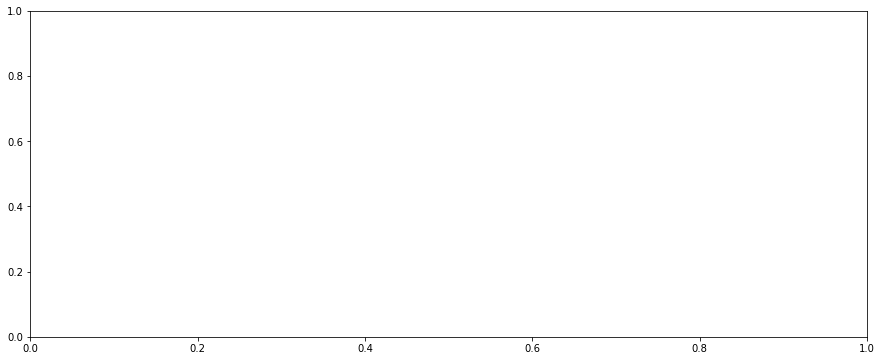

In [437]:

# Load the penguins dataset
#df = sns.load_dataset("penguins")

# Draw a categorical scatterplot to show each observation

f, ax = plt.subplots(figsize=(15, 6))
sns.swarmplot(x='fecha_reporte', y='fecha', ax=ax, data=df_stack)
ax.set(ylabel="")

In [428]:
df_stack = df.stack().reset_index()

In [432]:
df_stack.columns=['fecha','fecha_reporte','reparto']

In [433]:
df_stack

,fecha,fecha_reporte,reparto
0,2020-02-25,2020-09-02,0.0
1,2020-02-25,2020-09-03,0.0
2,2020-02-25,2020-09-04,0.0
3,2020-02-25,2020-09-07,0.0
4,2020-02-25,2020-09-08,0.0
...,...,...,...
5055,2020-10-01,2020-09-28,0.0
5056,2020-10-01,2020-09-29,0.0
5057,2020-10-01,2020-09-30,0.0
5058,2020-10-01,2020-10-01,0.0


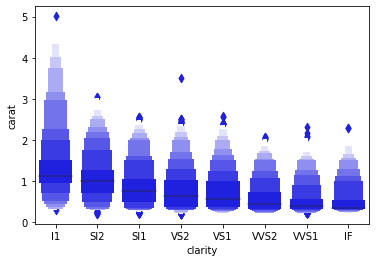

In [440]:
diamonds = sns.load_dataset("diamonds")
clarity_ranking = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]

sns.boxenplot(x="clarity", y="carat",
              color="b", order=clarity_ranking,
              scale="linear", data=diamonds)

In [442]:
diamonds

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


In [445]:
df_stack

,fecha,fecha_reporte,reparto
0,2020-02-25,2020-09-02,0.0
1,2020-02-25,2020-09-03,0.0
2,2020-02-25,2020-09-04,0.0
3,2020-02-25,2020-09-07,0.0
4,2020-02-25,2020-09-08,0.0
...,...,...,...
5055,2020-10-01,2020-09-28,0.0
5056,2020-10-01,2020-09-29,0.0
5057,2020-10-01,2020-09-30,0.0
5058,2020-10-01,2020-10-01,0.0


In [21]:
df1 = df.copy()

In [1]:
pd.set_option('display.max_columns', None)

NameError: name 'pd' is not defined

In [22]:
df1.tail(24)

,2020-09-01,2020-09-02,2020-09-03,2020-09-04,2020-09-07,2020-09-08,2020-09-09,2020-09-10,2020-09-11,2020-09-14,...,2020-09-21,2020-09-22,2020-09-23,2020-09-24,2020-09-25,2020-09-28,2020-09-29,2020-09-30,2020-10-01,2020-10-02
2020-09-08,NaN,0.0,0.0,0.0,0.0,0.0,1390.0,1171.0,468.0,1065.0,...,45.0,10.0,12.0,14.0,8.0,35.0,6.0,94.0,93.0,8.0
2020-09-09,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1236.0,1258.0,1241.0,...,34.0,14.0,8.0,13.0,7.0,27.0,16.0,63.0,73.0,10.0
2020-09-10,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,974.0,1867.0,...,42.0,11.0,9.0,12.0,12.0,35.0,10.0,98.0,113.0,12.0
2020-09-11,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3186.0,...,82.0,15.0,15.0,17.0,11.0,40.0,4.0,100.0,117.0,12.0
2020-09-12,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1353.0,...,23.0,4.0,6.0,2.0,3.0,12.0,2.0,6.0,5.0,2.0
2020-09-13,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,705.0,...,33.0,6.0,2.0,1.0,1.0,13.0,3.0,1.0,4.0,1.0
2020-09-14,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,170.0,7.0,10.0,5.0,3.0,14.0,4.0,6.0,6.0,3.0
2020-09-15,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1377.0,65.0,18.0,24.0,30.0,49.0,12.0,40.0,50.0,12.0
2020-09-16,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1594.0,682.0,13.0,81.0,20.0,51.0,11.0,15.0,17.0,12.0
2020-09-17,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2193.0,440.0,662.0,240.0,21.0,117.0,12.0,20.0,17.0,11.0


In [23]:

ref= dt.datetime.strptime(df.columns[0],'%Y-%m-%d')
rango = (dt.datetime.strptime(df.columns[-1],'%Y-%m-%d')-ref).days
for orden,columna in enumerate(df1.columns):
    desplazamiento = rango-(dt.datetime.strptime(columna, '%Y-%m-%d')-ref).days
    df1[columna] = df1[columna].shift(periods=desplazamiento)
    print (columna,desplazamiento)
df1.index = np.arange(-len(df1.index),0)+1

2020-09-01 31
2020-09-02 30
2020-09-03 29
2020-09-04 28
2020-09-07 25
2020-09-08 24
2020-09-09 23
2020-09-10 22
2020-09-11 21
2020-09-14 18
2020-09-15 17
2020-09-16 16
2020-09-17 15
2020-09-18 14
2020-09-21 11
2020-09-22 10
2020-09-23 9
2020-09-24 8
2020-09-25 7
2020-09-28 4
2020-09-29 3
2020-09-30 2
2020-10-01 1
2020-10-02 0


In [24]:
df1.tail(25)

,2020-09-01,2020-09-02,2020-09-03,2020-09-04,2020-09-07,2020-09-08,2020-09-09,2020-09-10,2020-09-11,2020-09-14,...,2020-09-21,2020-09-22,2020-09-23,2020-09-24,2020-09-25,2020-09-28,2020-09-29,2020-09-30,2020-10-01,2020-10-02
-24,NaN,2.0,0.0,0.0,16.0,1.0,5.0,2.0,4.0,33.0,...,23.0,13.0,7.0,7.0,7.0,29.0,6.0,5.0,2.0,4.0
-23,NaN,1.0,3.0,0.0,32.0,1.0,1.0,4.0,11.0,31.0,...,31.0,3.0,3.0,11.0,5.0,30.0,5.0,1.0,16.0,8.0
-22,NaN,2.0,3.0,0.0,16.0,1.0,20.0,9.0,9.0,27.0,...,10.0,3.0,2.0,9.0,4.0,10.0,3.0,6.0,93.0,10.0
-21,NaN,4.0,9.0,0.0,11.0,1.0,10.0,9.0,10.0,5.0,...,9.0,4.0,10.0,11.0,9.0,6.0,1.0,94.0,73.0,12.0
-20,NaN,2.0,7.0,0.0,20.0,7.0,2.0,6.0,6.0,16.0,...,13.0,13.0,8.0,8.0,10.0,19.0,6.0,63.0,113.0,12.0
-19,NaN,22.0,10.0,0.0,41.0,8.0,7.0,10.0,7.0,29.0,...,38.0,5.0,8.0,13.0,3.0,35.0,16.0,98.0,117.0,2.0
-18,NaN,15.0,3.0,0.0,89.0,12.0,11.0,6.0,3.0,31.0,...,34.0,9.0,11.0,3.0,1.0,27.0,10.0,100.0,5.0,1.0
-17,NaN,3.0,0.0,0.0,134.0,15.0,8.0,0.0,4.0,32.0,...,26.0,6.0,5.0,0.0,2.0,35.0,4.0,6.0,4.0,3.0
-16,NaN,0.0,4.0,0.0,240.0,8.0,1.0,5.0,10.0,44.0,...,50.0,2.0,3.0,7.0,8.0,40.0,2.0,1.0,6.0,12.0
-15,NaN,4.0,12.0,0.0,33.0,1.0,1.0,14.0,16.0,17.0,...,17.0,1.0,4.0,14.0,7.0,12.0,3.0,6.0,50.0,12.0


In [25]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)
cmap = sns.color_palette("rocket_r")

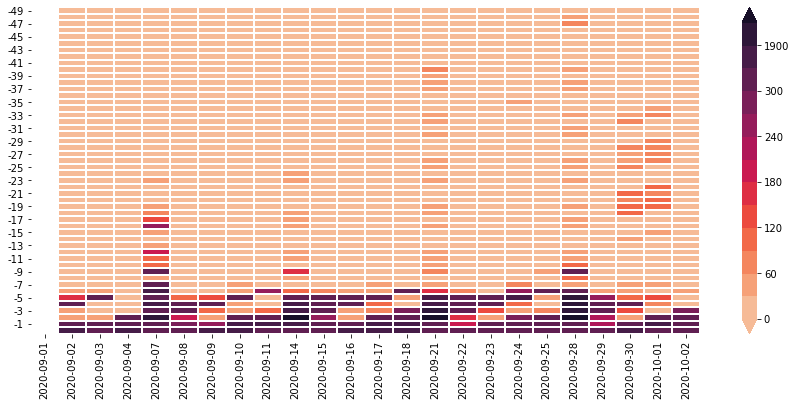

In [32]:
f, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(df1[df1.index>-50], annot=False, cmap=cmap, norm=norm,linewidths=1, ax=ax)

In [26]:
rango_valores_1 = np.arange(0,300,30)
rango_valores_2 = np.arange(300,3000,800)
rango_valores = np.concatenate([rango_valores_1,rango_valores_2])
colores = sns.color_palette("rocket_r",len(rango_valores)+1)
cmap, norm = colors.from_levels_and_colors(
    rango_valores, 
    colores,extend = 'both')